In [2]:
import yaml
import os
from towbintools.foundation import file_handling as file_handling
import pandas as pd

import numpy as np
import argparse
import matplotlib.pyplot as plt

from towbintools.data_analysis import compute_growth_rate_per_larval_stage, correct_series_with_classification, filter_series_with_classification, compute_larval_stage_duration, compute_series_at_time_classified, compute_series_at_ecdysis_classified, rescale_and_aggregate

from scipy import interpolate
import seaborn as sns
import starbars
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

from plotting_functions import plot_aggregated_series, plot_correlation, plot_correlation_at_molt, boxplot_at_molt, plot_growth_curves_individuals, plot_deviation_from_model_at_ecdysis, plot_normalized_proportions

In [3]:
filemap_path = "/mnt/towbin.data/shared/kstojanovski/20240625_Orca_10x_yap-1aid-raga-1aid_wBT186-437-438-439_25C_20240625_154359_670/analysis/report/analysis_filemap_annotated.csv"
config_path = '../config.yaml'
experiment_filemap = pd.read_csv(filemap_path)
experiment_filemap.head()

organ_channels = {'body' : 2, 'pharynx' : 1}

In [4]:
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    file.close()

def build_conditions(config):
    conditions = []
    condition_id = 0

    for condition in config["conditions"]:
        condition = {key: [val] if not isinstance(val, list) else val for key, val in condition.items()}

        lengths = set(len(val) for val in condition.values())
        if len(lengths) > 2 or (len(lengths) == 2 and 1 not in lengths):
            raise ValueError("All lists in the condition must have the same length or be of length 1.")

        max_length = max(lengths)
        for i in range(max_length):
            condition_dict = {
                key: val[0] if len(val) == 1 else val[i]
                for key, val in condition.items()
            }
            condition_dict["condition_id"] = condition_id
            conditions.append(condition_dict)
            condition_id += 1

    return conditions
    
conditions = build_conditions(config)
print(conditions)

conditions_keys = list(conditions[0].keys())

# remove 'point_range' and 'pad' from the conditions keys if they are present
if 'point_range' in conditions_keys:
    conditions_keys.remove('point_range')
if 'pad' in conditions_keys:
    conditions_keys.remove('pad')

[{'auxin_concentration_um': 0, 'strain': 'wBT186', 'point_range': [0, 26], 'condition_id': 0}, {'auxin_concentration_um': 0, 'strain': 'wBT437', 'point_range': [27, 54], 'condition_id': 1}, {'auxin_concentration_um': 0, 'strain': 'wBT438', 'point_range': [55, 86], 'condition_id': 2}, {'auxin_concentration_um': 0, 'strain': 'wBT439', 'point_range': [87, 120], 'condition_id': 3}, {'auxin_concentration_um': 10, 'strain': 'wBT186', 'point_range': [121, 147], 'condition_id': 4}, {'auxin_concentration_um': 10, 'strain': 'wBT437', 'point_range': [148, 176], 'condition_id': 5}, {'auxin_concentration_um': 10, 'strain': 'wBT438', 'point_range': [177, 204], 'condition_id': 6}, {'auxin_concentration_um': 10, 'strain': 'wBT439', 'point_range': [205, 232], 'condition_id': 7}, {'auxin_concentration_um': 50, 'strain': 'wBT186', 'point_range': [233, 250], 'condition_id': 8}, {'auxin_concentration_um': 50, 'strain': 'wBT437', 'point_range': [251, 274], 'condition_id': 9}, {'auxin_concentration_um': 50, 

In [5]:
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch2_seg',
       'analysis/ch1_seg', 'analysis/ch1_ch2_raw_str', 'analysis/ch1_seg_str',
       'analysis/ch2_seg_str', 'ch1_seg_str_volume', 'ch1_seg_str_length',
       'ch1_seg_str_area', 'ch2_seg_str_volume', 'ch2_seg_str_length',
       'ch2_seg_str_area', 'ch2_seg_str_worm_type', 'HatchTime',
       'ch2_seg_str_volume_at_HatchTime', 'M1', 'ch2_seg_str_volume_at_M1',
       'M2', 'ch2_seg_str_volume_at_M2', 'M3', 'ch2_seg_str_volume_at_M3',
       'M4', 'ch2_seg_str_volume_at_M4', 'ch1_seg_str_volume_at_HatchTime',
       'ch1_seg_str_volume_at_M1', 'ch1_seg_str_volume_at_M2',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch1_seg_str_length_at_HatchTime', 'ch1_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M2', 'ch1_seg_str_length_at_M3',
       'ch1_seg_str_length_at_M4', 'ch2_seg_str_length_at_HatchTime',
       'ch2_seg_str_length_at_M1', 'ch2_seg_str_length_at_M2',
       'ch2_seg_str_le

In [6]:
def add_conditions_to_filemap(experiment_filemap, conditions, config):
    for condition in conditions:
        if "point_range" in condition.keys():
            point_range = condition["point_range"]
            # Get all the rows that are in the point range
            condition_rows = experiment_filemap[experiment_filemap["Point"].between(point_range[0], point_range[1])]
            # Remove the point range from the condition
            conditions_to_add = {key: val for key, val in condition.items() if key != "point_range"}
            for key, val in conditions_to_add.items():
                # Directly fill the rows with the value for the new or existing column
                experiment_filemap.loc[condition_rows.index, key] = val

        elif "pad" in condition.keys():
            pad = condition["pad"]
            # Get all the rows that are in the pad
            condition_rows = experiment_filemap[experiment_filemap["Pad"] == pad]
            # Remove the pad from the condition
            conditions_to_add = {key: val for key, val in condition.items() if key != "pad"}
            for key, val in conditions_to_add.items():
                # Directly fill the rows with the value for the new or existing column
                experiment_filemap.loc[condition_rows.index, key] = val
                
        else:
            print("Condition does not contain 'point_range' or 'pad' key, impossible to add condition to filemap, skipping.")
    return experiment_filemap

experiment_filemap = add_conditions_to_filemap(experiment_filemap, conditions, config)
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch2_seg',
       'analysis/ch1_seg', 'analysis/ch1_ch2_raw_str', 'analysis/ch1_seg_str',
       'analysis/ch2_seg_str', 'ch1_seg_str_volume', 'ch1_seg_str_length',
       'ch1_seg_str_area', 'ch2_seg_str_volume', 'ch2_seg_str_length',
       'ch2_seg_str_area', 'ch2_seg_str_worm_type', 'HatchTime',
       'ch2_seg_str_volume_at_HatchTime', 'M1', 'ch2_seg_str_volume_at_M1',
       'M2', 'ch2_seg_str_volume_at_M2', 'M3', 'ch2_seg_str_volume_at_M3',
       'M4', 'ch2_seg_str_volume_at_M4', 'ch1_seg_str_volume_at_HatchTime',
       'ch1_seg_str_volume_at_M1', 'ch1_seg_str_volume_at_M2',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch1_seg_str_length_at_HatchTime', 'ch1_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M2', 'ch1_seg_str_length_at_M3',
       'ch1_seg_str_length_at_M4', 'ch2_seg_str_length_at_HatchTime',
       'ch2_seg_str_length_at_M1', 'ch2_seg_str_length_at_M2',
       'ch2_seg_str_le

In [7]:
experiment_filemap["condition_id"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [8]:
conditions_struct = []

def get_ecdysis_and_durations(filemap):
    all_ecdysis_time_step = []
    all_durations_time_step = []

    all_ecdysis_experiment_time = []
    all_durations_experiment_time = []
    
    for point in filemap["Point"].unique():
        point_df = filemap[filemap["Point"] == point]
        point_ecdysis = point_df[["HatchTime", "M1", "M2", "M3", "M4"]].iloc[0]
        larval_stage_durations = list(compute_larval_stage_duration(point_ecdysis).values())

        point_ecdysis = point_ecdysis.to_numpy()
        all_ecdysis_time_step.append(point_ecdysis)
        all_durations_time_step.append(larval_stage_durations)

        ecdysis_experiment_time = []
        for ecdys in point_ecdysis:
            if np.isnan(ecdys):
                ecdysis_experiment_time.append(np.nan)
            else:
                ecdys_experiment_time = point_df[point_df["Time"] == ecdys]["ExperimentTime"].iloc[0]
                ecdysis_experiment_time.append(ecdys_experiment_time)

        all_ecdysis_experiment_time.append(ecdysis_experiment_time)
        
        durations_experiment_time = []
        for i in range(len(ecdysis_experiment_time) - 1):
            start = ecdysis_experiment_time[i]
            end = ecdysis_experiment_time[i + 1]
            duration_experiment_time = end - start
            durations_experiment_time.append(duration_experiment_time)

        all_durations_experiment_time.append(durations_experiment_time)
        
    return np.array(all_ecdysis_time_step), np.array(all_durations_time_step), np.array(all_ecdysis_experiment_time), np.array(all_durations_experiment_time)

def separate_column_by_point(filemap, column):
    separated_column = []
    for point in filemap["Point"].unique():
        point_df = filemap[filemap["Point"] == point]
        separated_column.append(point_df[column].values)
    return np.array(separated_column)
        
for condition_id in experiment_filemap["condition_id"].unique():
    condition_df = experiment_filemap[experiment_filemap["condition_id"] == condition_id]
    condition_dict = {}

    for key in conditions_keys:
        condition_dict[key] = condition_df[key].iloc[0]

    ecdysis_time_step, larval_stage_durations_time_step, ecdysis_experiment_time, larval_stage_durations_experiment_time = get_ecdysis_and_durations(condition_df)
    condition_dict['ecdysis_time_step'] = ecdysis_time_step
    condition_dict['larval_stage_durations_time_step'] = larval_stage_durations_time_step
    condition_dict['ecdysis_experiment_time'] = ecdysis_experiment_time
    condition_dict['larval_stage_durations_experiment_time'] = larval_stage_durations_experiment_time

    worm_type_column = [col for col in condition_df.columns if 'worm_type' in col][0]
    worm_types = separate_column_by_point(condition_df, worm_type_column)

    for organ in organ_channels.keys():
        organ_channel = organ_channels[organ]
        organ_channel = f'ch{organ_channel}'
        organ_columns = [col for col in condition_df.columns if col.startswith(organ_channel)]
        organ_columns = [col for col in organ_columns if not ('_at_' in col)]
        renamed_organ_columns = [col.replace(organ_channel, organ) for col in organ_columns]

        for organ_column, renamed_organ_column in zip(organ_columns, renamed_organ_columns):
            condition_dict[renamed_organ_column] = separate_column_by_point(condition_df, organ_column)

        # remove any column with worm_type in it
        renamed_organ_columns = [col for col in renamed_organ_columns if not ('worm_type' in col)]
        for column in renamed_organ_columns:
            condition_dict[f'{column}_at_ecdysis'] = np.stack([compute_series_at_ecdysis_classified(condition_dict[column][i], worm_types[i], ecdysis_time_step[i]) for i in range(len(ecdysis_time_step))])


    condition_dict['time'] = separate_column_by_point(condition_df, 'Time').astype(float)
    condition_dict['experiment_time'] = separate_column_by_point(condition_df, 'ExperimentTime').astype(float)

    conditions_struct.append(condition_dict)


Caught an exception while interpolating volume at time 184.0, returning nan : SVD did not converge in Linear Least Squares

Caught an exception while interpolating volume at time 86.0, returning nan : SVD did not converge in Linear Least Squares
Caught an exception while interpolating volume at time 184.0, returning nan : SVD did not converge in Linear Least Squares
Caught an exception while interpolating volume at time 86.0, returning nan : SVD did not converge in Linear Least Squares
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
Caught an exception while interpolating volume at time 184.0, returning nan : SVD did not converge in Linear Least Squares
Caught an exception while interpolating volume at time 86.0, returning nan : SVD did not converge in Linear Least Squares

Intel MK

/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/towbintools/data_analysis/time_series.py:232: RuntimeWarning: Mean of empty slice
  aggregated_larval_stage_durations = aggregation_function(larval_stage_durations, axis=0)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/towbintools/data_analysis/time_series.py:235: RuntimeWarning: Mean of empty slice
  aggregated_series[i, :] = aggregation_function(all_points_interpolated_series[:, i, :], axis=0)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


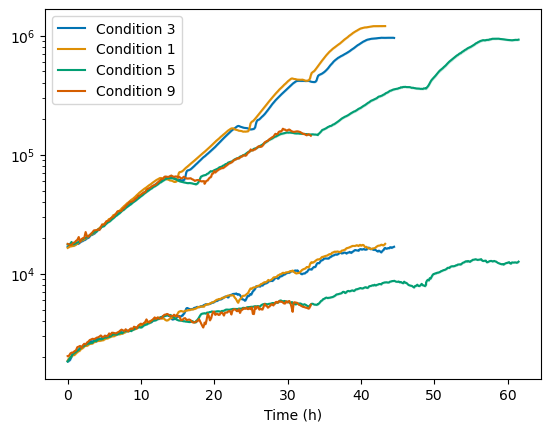

In [9]:
plot_aggregated_series(conditions_struct, ['body_seg_str_volume', 'pharynx_seg_str_volume'], [3, 1, 5, 9], experiment_time = True, aggregation='mean', n_points=100, time_step = 10, log_scale = True)

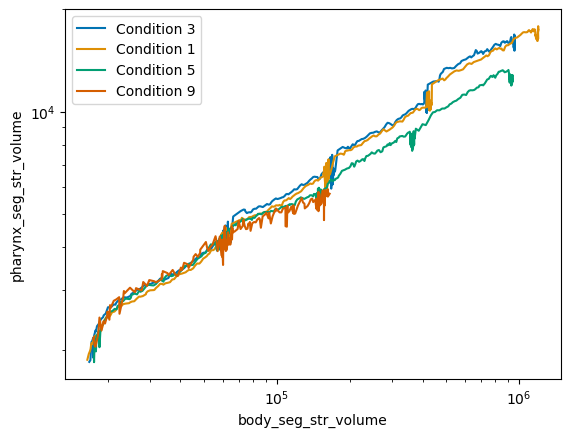

In [10]:
plot_correlation(conditions_struct, 'body_seg_str_volume', 'pharynx_seg_str_volume', [3, 1, 5, 9], log_scale = True)

/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:109: RuntimeWarning: Mean of empty slice
  x = np.nanmean(condition_dict[column_one], axis=0)
/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:113: RuntimeWarning: Mean of empty slice
  y = np.nanmean(condition_dict[column_two], axis=0)


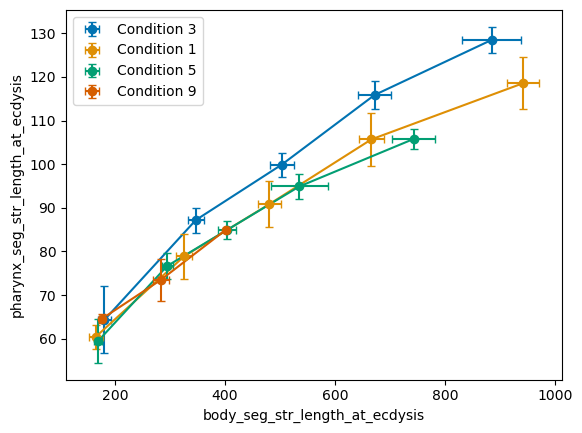

In [11]:
plot_correlation_at_molt(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', [3, 1, 5, 9], log_scale = False)

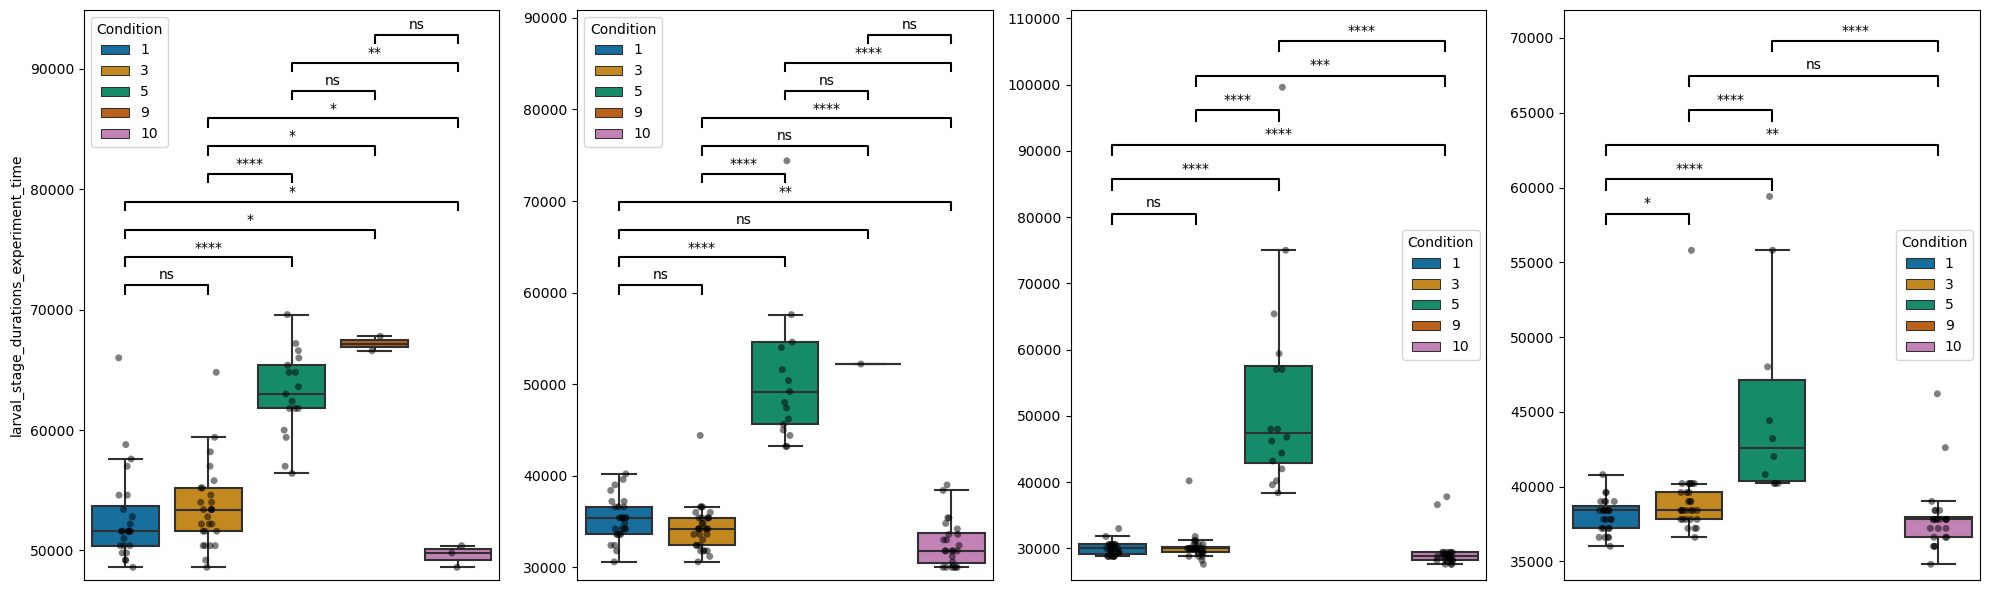

In [18]:
boxplot_at_molt(conditions_struct, 'larval_stage_durations_experiment_time', [3, 1, 5, 9, 10], log_scale = False, plot_significance=True)

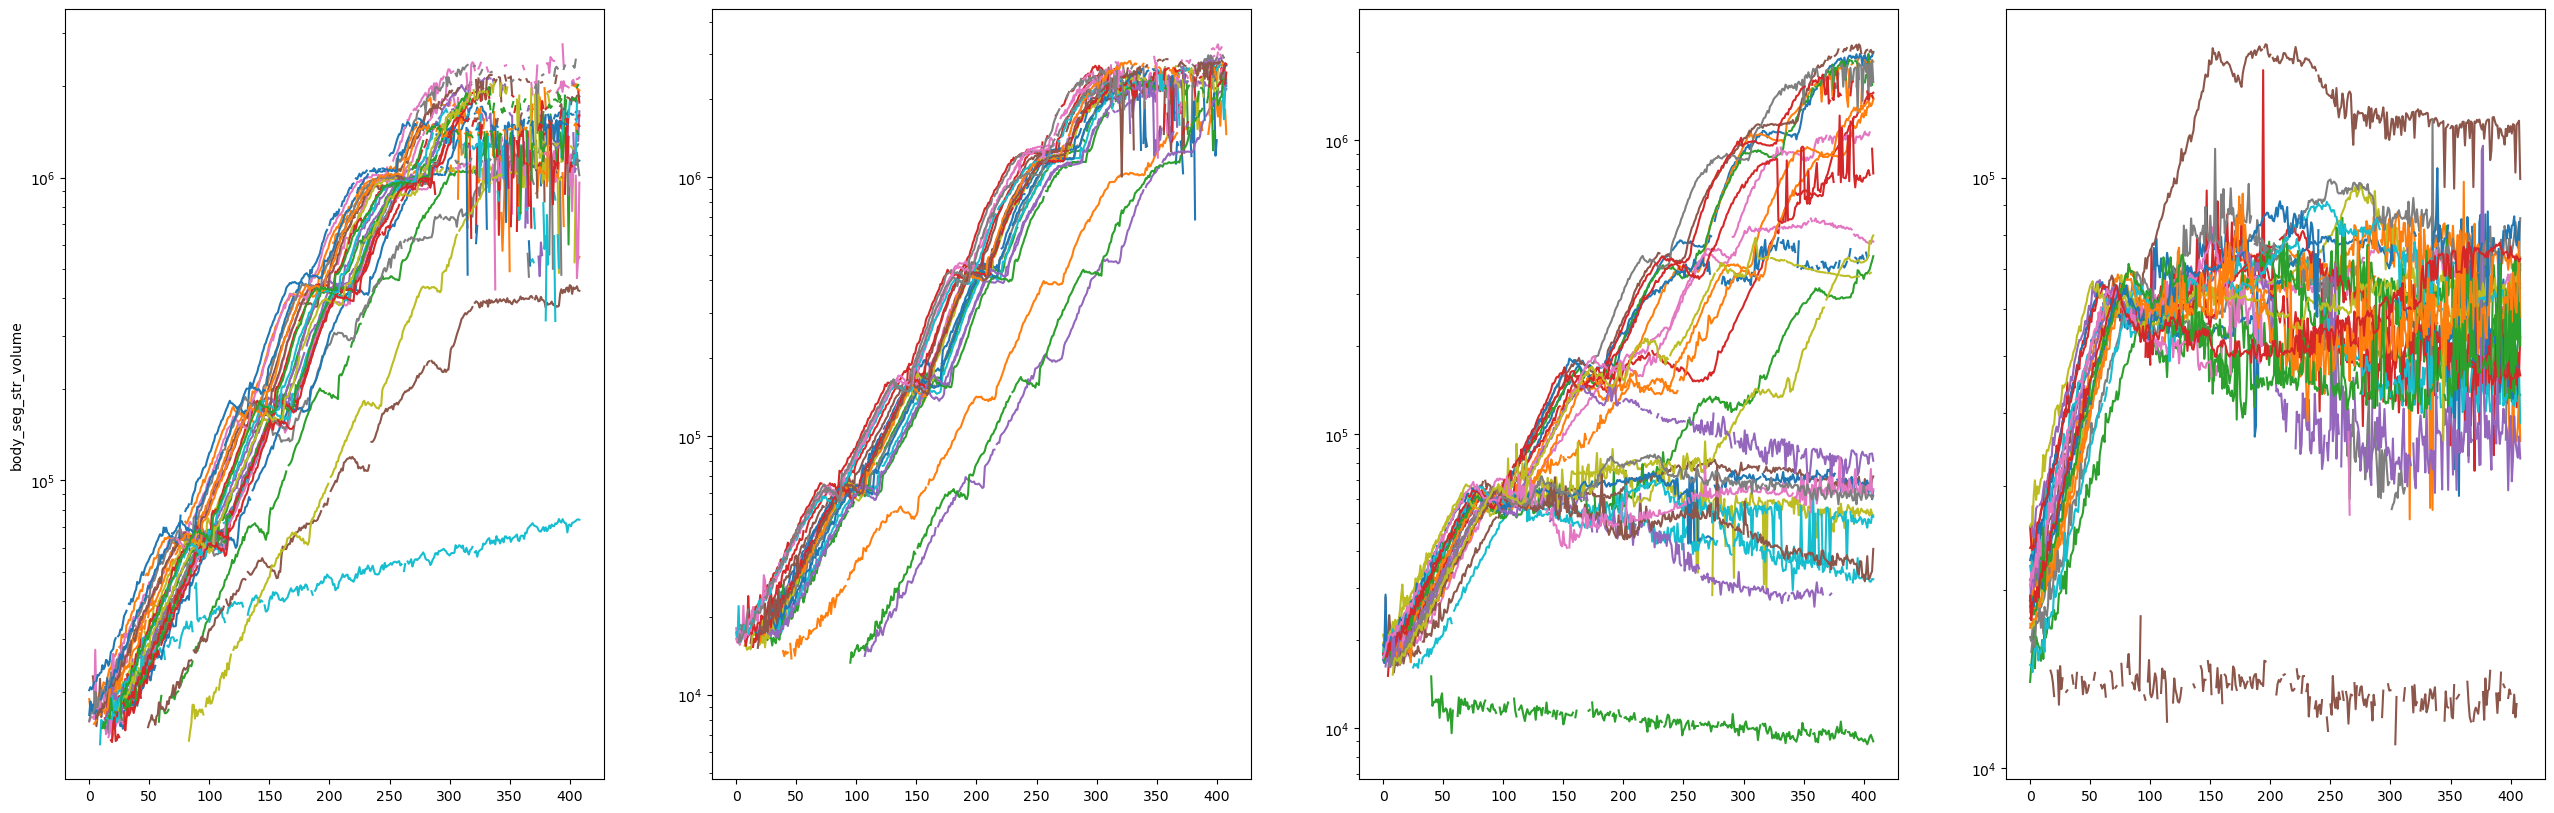

In [13]:
plot_growth_curves_individuals(conditions_struct, 'body_seg_str_volume', [3, 1, 5, 9], log_scale = True)

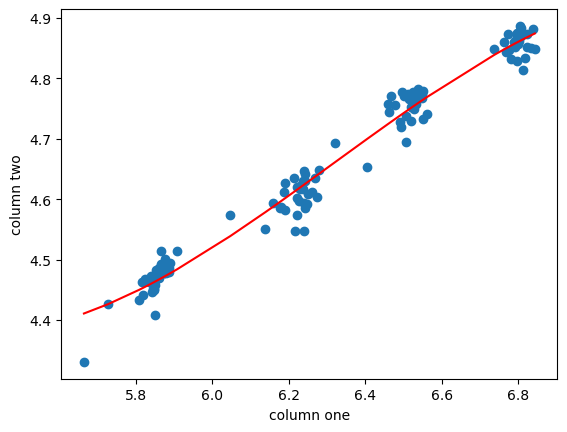

/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:291: RuntimeWarning: Mean of empty slice
  y = np.nanmean(residuals, axis=0)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:293: RuntimeWarning: Mean of empty slice
  x = np.nanmean(np.exp(series_one_at_ecdysis), axis=0)


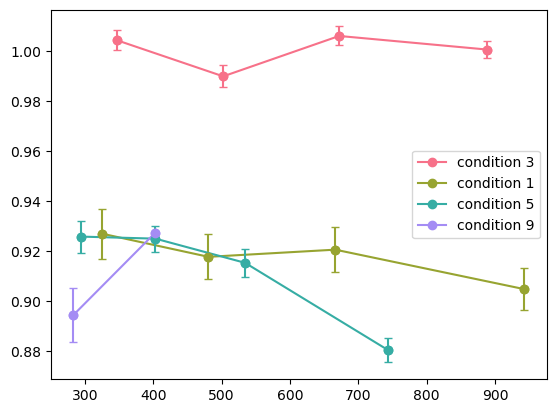

In [14]:
plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "pharynx_seg_str_length_at_ecdysis", 3, [3, 1, 5, 9], remove_hatch=True)

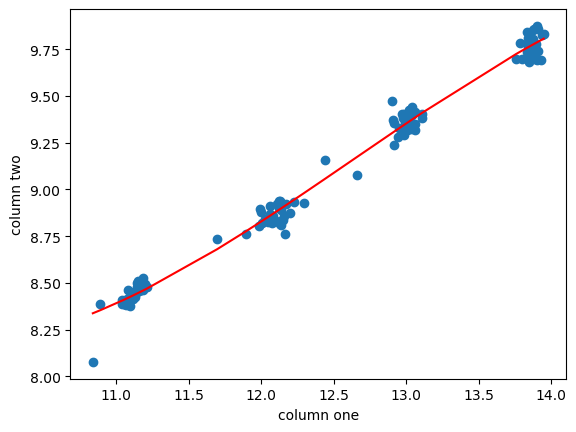

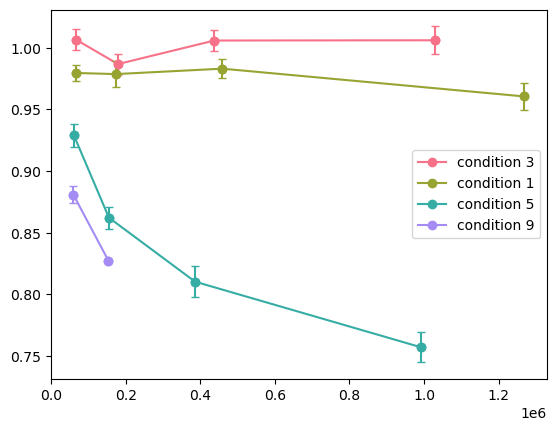

In [15]:
plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_volume_at_ecdysis", "pharynx_seg_str_volume_at_ecdysis", 3, [3, 1, 5, 9], remove_hatch=True)

/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:331: RuntimeWarning: Mean of empty slice
  y = aggregation_function(normalized_proportion, axis=0)
/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:333: RuntimeWarning: Mean of empty slice
  x = aggregation_function(condition_column_one, axis=0)


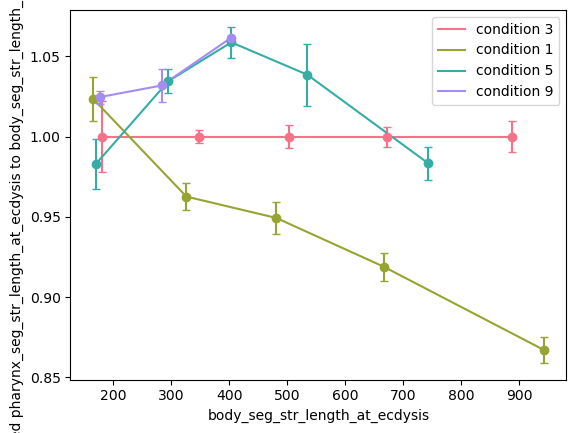

In [16]:
plot_normalized_proportions(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', 3, [3, 1, 5, 9], log_scale = False)

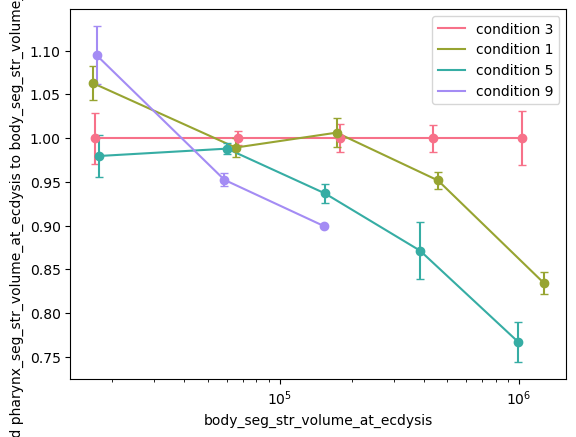

In [17]:
plot_normalized_proportions(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', 3, [3, 1, 5, 9], log_scale = True)